<a href="https://colab.research.google.com/github/tuncermerve/respiratory_rate_estimation/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Respiratory Rate Estimation

Seismocardiography ([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure the Heart Rate (HR) and Respiratory Rate (RR) with a detector positioned above the sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography ([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with a combination of both an accelerometer and a gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., the accelerometer platform can be mounted under the slats of the bed).   
  
MuSe (Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provided by [221e](https://www.221e.com). In the context of this project, it allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the respiratory rate of an healthy subject, given the linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform.

The study must be performed on two datasets: the first is the compulsory one (`center_sternum.txt`), while the second is left at the discretion of the group, among those made available for the assignment.

*Remember that normal heart rate is around [40-100] bpm.*


## Data

The data is provided in `.txt` files. During this study, two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject. 

This is the first mandatory file:

* `center_sternum.txt`: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively. 


Choose one of the following files in order to complete the task.

* `1_Stave_supine_static.txt`: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side. 
* `2_Mattress_supine.txt`: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above. 
* `3_Subject_sitting_chair.txt`: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk. 
* `4_Chest_sweater.txt`: Sensor placed on the subject chest directly on a sweater. 
* `5_Under_chair.txt`: Subject sitting on a chair, sensor placed under the seat of the chair. 

All `.txt` files have 16 columns, containing: 

* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(`config_1.txt` for the first measurement, and in `config_5.txt` for the other measurement).
 


## Assignment



1. Data preparation:

    1.1. Load the txt files and select only the columns you are interested in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )
    
    1.2. Plot selected data as a function of time and choose a proper time window over which to perform the analysis. Pay attention on the time representation and the measurement unit.
    
    1.3. In order to do a proper job, decide whether to consider some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.  


    
2. Time and frequency analysis:

    2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.
    
    2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use the Fourier analysis to properly design the filters in the following step. 



3. Filter:
    
    Implement your own filter, trying to extrapolate the respiratory rate signal. Hints:
    
    (a) Directly from Fourier Analysis, look for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
        
    (c) Explore another methods by yourselves.
    
    Remember to always motivate your choice.
    
    
4. Metrics:

    4.1. Respiratory Rate Per Minute (RPM): extrapolate RPM, and make an histogram of the result. Does it follow a particular distribution?

    4.2. Respiratory Rate Variability (RRV): extrapolate RRV, explain why this parameter is important, and plot the results.


5. **Optional**: Elaborate a simple algorithm to extrapolate the respiratory rate even when the filter fails (e.g. look for a particular threshold...).  



6. Conclusion: 

    Summarise the obtained results, and specifically make a comparison between the two files analysed. Highlight the limitations and the critical issues encountered during the work, motivating the most relevant contribution given by your solution.

# Adding spesific libraries

In [1]:
#Importing necessary Libraries
import pandas as pd
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy import fft, signal, interpolate, fftpack
import scipy as spy
from statistics import mean

# Analysis for center_sternum.txt

# Data Preparation

In [2]:
file = "center_sternum.txt"  #Actual File
data = pd.read_csv(file, delimiter="\t") #read csv 

data

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
16502,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
16503,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502
16504,5,200,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124,0.648973,0.381329,-0.637348,0.164953


We have decided to select the columns related with magnitude of linear acceleration,  magnitude of angular velocity, magnitude of magnetic field.
The reason why is because the spatial orientations give the orientation of the body, which is not necessary for the solution

# Dropping the unnecessary columns

In [3]:
#dropping the columns which wont be used anymore (qw,qi,qj,qk) 

df = pd.DataFrame(data)
df.drop(df.columns[[12,13,14,15]],inplace=True,axis=1) 
df

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176
...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126
16502,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125
16503,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125
16504,5,200,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124


we dropped the columns which wont be used anymore (qw,qi,qj,qk) .


# Plot selected data wrt the time window

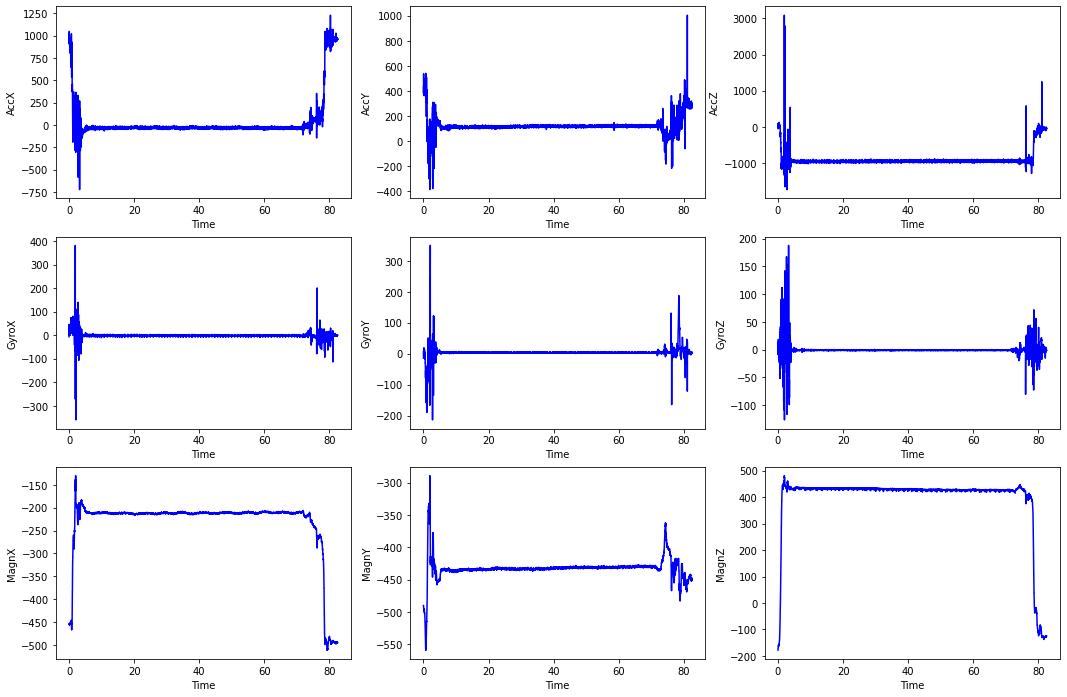

In [4]:
sampling_frequency = 200  #Given in the configuration file
limits = np.linspace(0,df.shape[0]/sampling_frequency ,df.shape[0])  #starts from 0, goes untill stop number, number of samples to generate is df.shape[0]

#labels = df[:0]
labels = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']
fig, axes = plt.subplots(3, 3, figsize = (18, 12))
for i ,axs in enumerate(axes.flat):
    axs.plot(limits, df[labels[i]], color = 'blue')
    axs.set_xlabel('Time')
    axs.set_ylabel(labels[i])

In the following cells, we wanted to see some plots to explore the data in details,based on the variables AccX,AccY and AccZ which is the linear acceleration.


# Choosing a proper time window

It can be easily seen that the first 5 seconds and the last 20 seconds, starting with 70th second are very noisy. This analysis will affect the selecting procedure of the time window.
When we examined the graphs above, we extracted the frequency ranges of noisy data from 0-5 and after 65 seconds in these graphs.

In [5]:
min_time = 1000 #for the first 5 seconds  (5*200)
max_time = 13000 #for the 65th time frame 65*200
df = df.iloc[min_time:max_time].copy()
df



,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
1000,5,200,1576222776,-44.347,137.311,-952.698,0.671756,4.351145,0.564886,-208,-451,429
1001,5,200,1576222776,-45.750,131.821,-954.040,0.885496,4.106870,0.091603,-208,-450,429
1002,5,200,1576222776,-45.018,133.895,-951.112,1.450382,4.015267,-0.549618,-208,-450,429
1003,5,200,1576222776,-49.166,133.529,-947.208,1.603053,4.061069,-0.595420,-208,-450,430
1004,5,200,1576222776,-66.612,139.080,-925.675,1.587786,3.648855,-0.732824,-208,-450,430
...,...,...,...,...,...,...,...,...,...,...,...,...
12995,5,200,1576222831,-31.842,118.279,-941.901,-1.679389,3.664122,-0.503817,-210,-430,426
12996,5,200,1576222831,-40.626,116.998,-949.404,-1.129771,4.015267,-0.519084,-210,-430,426
12997,5,200,1576222831,-33.062,116.693,-949.404,-1.114504,3.587786,-0.717557,-210,-429,428
12998,5,200,1576222831,-25.254,118.523,-961.787,-1.557252,3.938931,-0.641221,-210,-429,428


# Calibrating linear acceleration, angular velocity and magnetic field

In the calibration process, the deviations of the test-measurement instrument or devices used in the measurement are determined and the errors are corrected. Thus, since the accuracy of all devices in the measuring chain is finalized, the reliability of the measurement results is ensured.

In [6]:
accelometer_calibration = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
transpose_a = accelometer_calibration.T
accelometer_offset = np.array([-3.929942,-13.74679,60.67546])

gyroscope_offset = np.array([-2.242224,2.963463,-0.718397])

magneticfield_calibration = np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])

transpose_m = magneticfield_calibration
magneticfield_offset = np.array([-95.67974,-244.9142,17.71132])




df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyroscope_offset
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']], transpose_a) + accelometer_offset
df[['MagnX','MagnY','MagnZ']] = np.dot(df[['MagnX','MagnY','MagnZ']], transpose_m) + magneticfield_offset
df



,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
1000,5,200,1576222776,-47.972764,122.211301,-896.042475,-1.570468,7.314608,-0.153511,-274.911150,-650.860423,390.356463
1001,5,200,1576222776,-49.363409,116.843545,-897.380442,-1.356728,7.070333,-0.626794,-274.934402,-649.945547,390.360721
1002,5,200,1576222776,-48.637575,118.867164,-894.444350,-0.791842,6.978730,-1.268015,-274.934402,-649.945547,390.360721
1003,5,200,1576222776,-52.791461,118.512592,-890.521151,-0.639171,7.024532,-1.313817,-274.930921,-649.941290,391.235521
1004,5,200,1576222776,-70.282292,123.952786,-868.897722,-0.654438,6.612318,-1.451221,-274.930921,-649.941290,391.235521
...,...,...,...,...,...,...,...,...,...,...,...,...
12995,5,200,1576222831,-35.418961,103.538868,-885.181384,-3.921613,6.627585,-1.222214,-277.248450,-631.614297,387.814507
12996,5,200,1576222831,-44.203217,102.317144,-892.706502,-3.371995,6.978730,-1.237481,-277.248450,-631.614297,387.814507
12997,5,200,1576222831,-36.631201,102.001043,-892.711324,-3.356728,6.551249,-1.435954,-277.264740,-630.690906,389.568364
12998,5,200,1576222831,-28.811253,103.792989,-905.152510,-3.799476,6.902394,-1.359618,-277.264740,-630.690906,389.568364


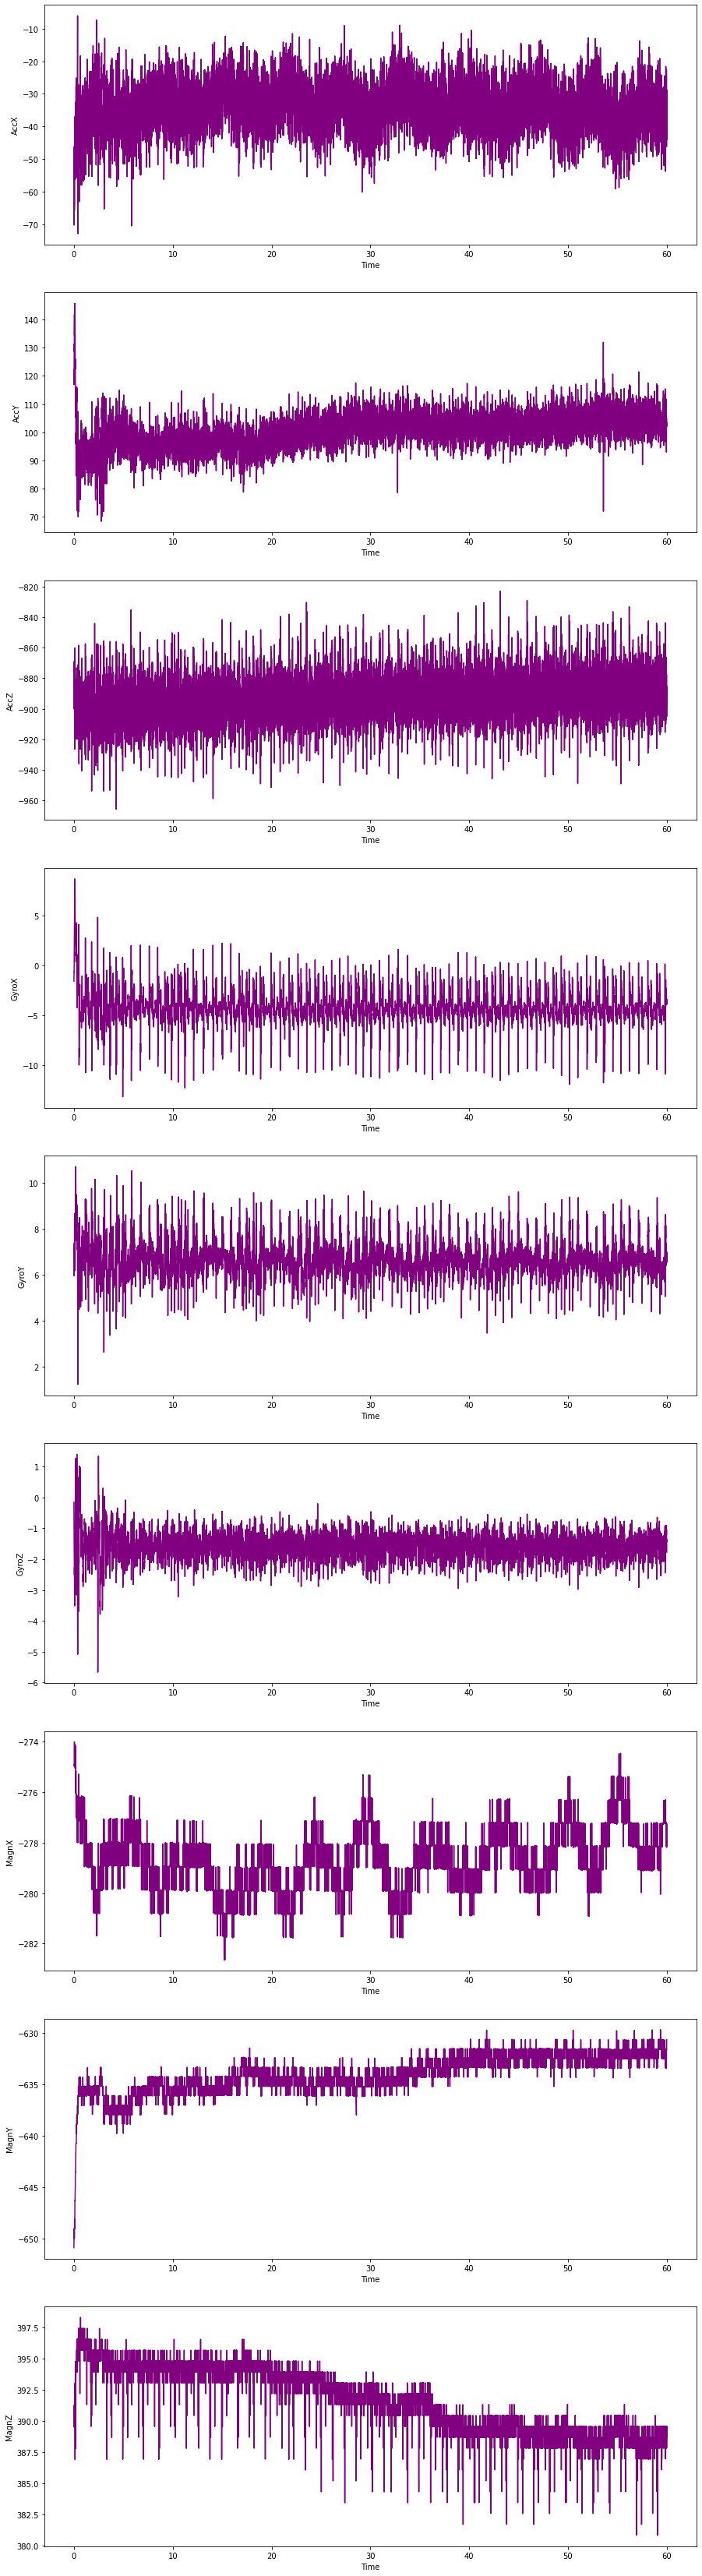

In [7]:
fig, axes = plt.subplots(9, 1, figsize = (15, 60))
limits = np.linspace(0,df.shape[0]/sampling_frequency ,df.shape[0]) 
for i ,axs in enumerate(axes.flat):
    axs.plot(limits, df[labels[i]], color = 'purple')
    axs.set_xlabel('Time')
    axs.set_ylabel(labels[i])
    


After the noisy data we extracted here, we poured the rest into the table. Graph of range values.

# 2.0 Time and Frequency Analysis

# Statistical Analysis

Mean median variance standard deviation 25th and 75th percentiles

In [8]:
df.drop(df.columns[[0,1,2]],inplace=True,axis=1)
#describe functions gives mean median std 25 and 75 percentiles
df.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,-34.362789,100.236260,-893.446564,-4.279313,6.666018,-1.580174,-278.684194,-634.047740,391.593380
std,7.299004,5.979027,14.677326,1.568470,0.762057,0.432705,1.219443,1.858629,2.645261
min,-72.909656,68.267420,-965.972795,-13.127724,1.238272,-5.664962,-282.650268,-650.860423,380.808368
25%,-39.019581,96.645065,-902.262602,-4.944514,6.230639,-1.832901,-279.110272,-635.197494,389.548630
50%,-34.232411,100.537349,-893.801576,-4.379629,6.612318,-1.573359,-278.966165,-634.255109,392.156778
75%,-29.541448,103.959481,-885.421664,-3.662071,6.993997,-1.329084,-278.046880,-632.501664,393.914116
max,-6.053036,145.757075,-822.777963,8.658536,10.703921,1.403740,-274.011636,-629.710532,398.295078


 The most interesting descriptors for this type of data, motivating the choice is mean.

Correlation coefficients analysis we made it with heat map because it looks way much better and for the analyzing correlation its make easier.

           AccX      AccY      AccZ  ...     MagnX     MagnY     MagnZ
AccX   1.000000 -0.181279 -0.385553  ... -0.390199  0.061852  0.034458
AccY  -0.181279  1.000000  0.174155  ...  0.223666  0.211834 -0.494558
AccZ  -0.385553  0.174155  1.000000  ...  0.097910  0.176900 -0.249058
GyroX  0.167049  0.016331 -0.082519  ...  0.015488 -0.178052  0.035769
GyroY -0.004051 -0.000945  0.097114  ...  0.044450 -0.164316  0.037452
GyroZ -0.000826 -0.112597  0.004089  ...  0.014632 -0.068802  0.024974
MagnX -0.390199  0.223666  0.097910  ...  1.000000  0.059070 -0.240942
MagnY  0.061852  0.211834  0.176900  ...  0.059070  1.000000 -0.667162
MagnZ  0.034458 -0.494558 -0.249058  ... -0.240942 -0.667162  1.000000

[9 rows x 9 columns]


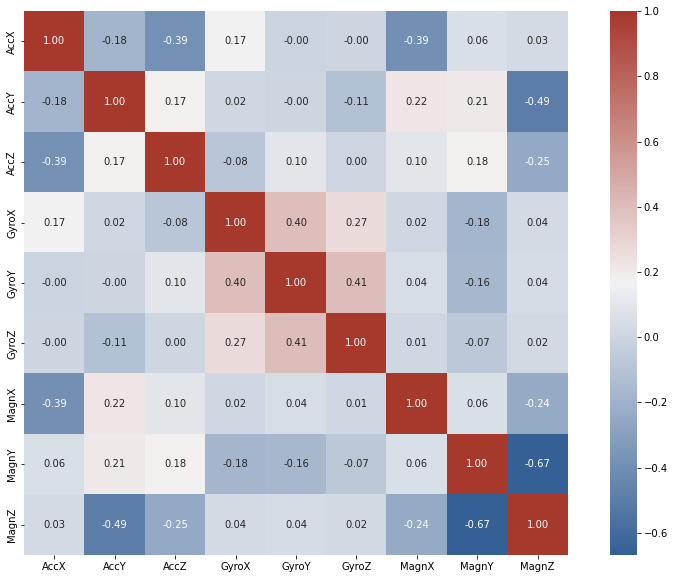

In [9]:
#We wanted to find a correlation matrix in order to see the correlation among the variables. 
#Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize the data as a diagnostic for adcanced analyses
def plot_correlation_matrix(data):
    #this correlation matrix has coefficients ranges from 1 to -1, while -1 refers to negative correlation and +1 perfect positive correllation.
    plt.subplots(figsize=(15, 10))
    corr_matrix = data.corr() #Compute pairwise correlation of columns, excluding NA/null values
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True) #custom diverging palette with red blue and white to use it in the heatmap
    
    sns.heatmap(corr_matrix, annot=True, 
                fmt='.2f', square=True, cmap=cmap) #heatmap: a graphical representation of data that uses a system of color-coding to represent different values.
    return corr_matrix,corr_matrix

corr_matrix,correlation_coefficients = plot_correlation_matrix(df)
print(correlation_coefficients)


# Fourier Analysis

Generally, for signal analysis the FFT is used on signals of infinite 
length.  So, when you chop up your signal into finite-length segments, 
you are making an approximation.  Detrending the signal makes this 
approximation better



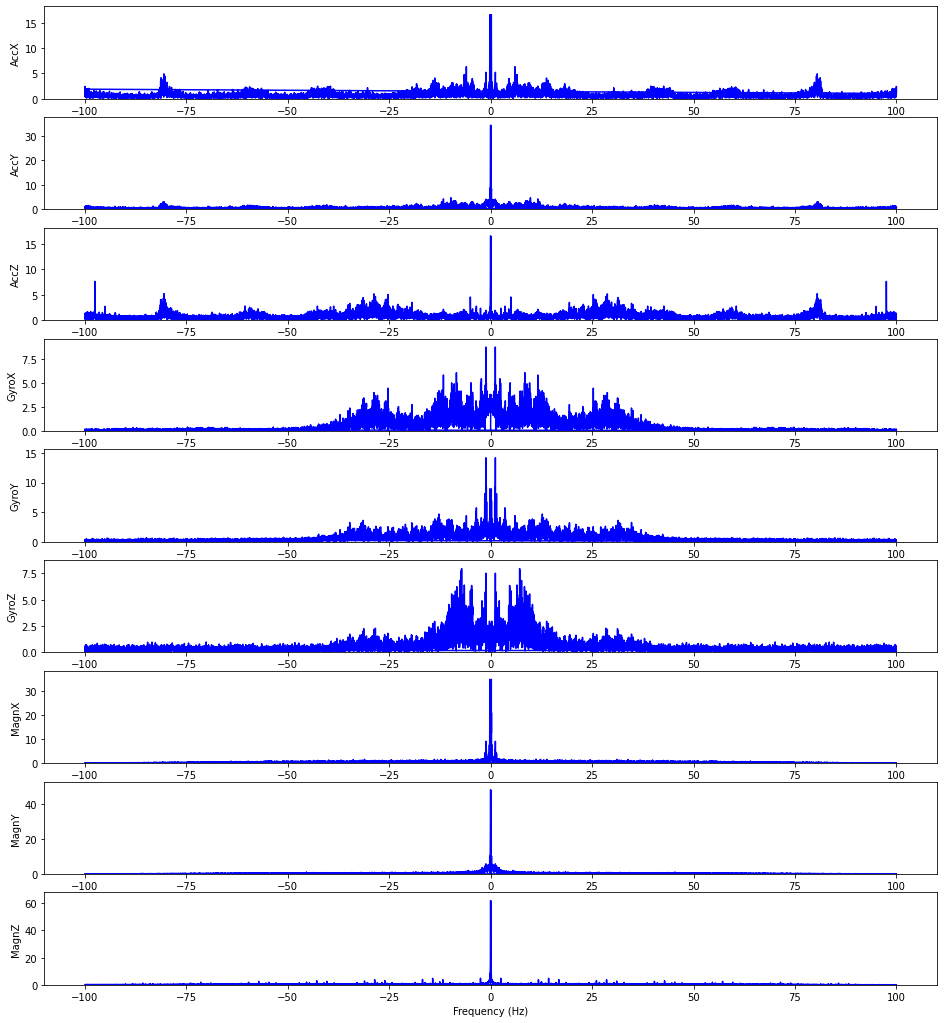

In [10]:
#Fourier analysis can be achieved by using pythons fft and fft freq
from scipy import fft, signal, interpolate
from sklearn import preprocessing
#normalizing the data:
df_mean = df.apply(np.mean)
df = df- df_mean
normalized_df = pd.DataFrame(preprocessing.normalize(df, axis=0), columns=df.columns)


fourier = normalized_df.apply(np.fft.fft)
absolute = fourier.apply(np.abs)

frequency = fft.fftfreq(absolute.shape[0] , d=1/200)


fig, axs = plt.subplots(9,1, figsize = (16,18))
for i, ax in enumerate(axs.flat):   
    az = np.array(absolute.iloc[:,i])
    find_peaks, _property = signal.find_peaks(az, distance=200)
    
        
    ax.set_ylim([0, az[find_peaks].max()*1.1])
    ax.plot(frequency, az, color='blue')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(absolute.columns[i])


The Fourier transform states that all disordered waves can actually be written as the sum of the series of sines. All continuous waves, all audio files are actually the sum of sinuses that differ from each other in frequency and power. This sum actually goes to infinity because it is impossible to index a continuous wave perfectly to the sum of sines. In general, the coefficient of this sine decreases as the frequency value increases. In these examples, the reason why the Fourier transform is symmetric (f=10k is equivalent to f=-10k) is that the imaginary part of the analyzed wave is 0.
If we evaluate the graphics in the light of this information:

In the first graph, we see a graph with larger power values spread over a wider area as a result of the transformation. If we apply the inverse Fourier to this function, we will encounter a very noisy continuous wave, because frequencies of very large amplitude are seen at many different frequency values, which indicates that our frequency has an irregular structure.


Especially the graphics in the last picture belong to 2 very regular continuous waves, which when they are put into the inverse Fourier transform, we encounter 2 waves that are not very dispersed. The reason for this is that we have not encountered a large sine value other than our fundamental frequency value (f=0).

Since AccX and AccZ peak in the 80 Hz range, they can be taken because they are closer to a healthy human heartbeat.

In [11]:
normalized_df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,-0.017022,0.033553,-0.001615,0.015767,0.007770,0.030099,0.028246,-0.082579,-0.004269
1,-0.018762,0.025357,-0.002447,0.017011,0.004844,0.020114,0.028072,-0.078086,-0.004254
2,-0.017854,0.028447,-0.000621,0.020298,0.003746,0.006586,0.028072,-0.078086,-0.004254
3,-0.023049,0.027905,0.001820,0.021187,0.004295,0.005620,0.028098,-0.078065,-0.001235
4,-0.044926,0.036212,0.015269,0.021098,-0.000643,0.002721,0.028098,-0.078065,-0.001235
...,...,...,...,...,...,...,...,...,...
11995,-0.001321,0.005043,0.005141,0.002082,-0.000460,0.007552,0.010748,0.011952,-0.013041
11996,-0.012308,0.003177,0.000460,0.005281,0.003746,0.007230,0.010748,0.011952,-0.013041
11997,-0.002837,0.002695,0.000457,0.005370,-0.001375,0.003043,0.010626,0.016488,-0.006989
11998,0.006943,0.005431,-0.007281,0.002793,0.002832,0.004653,0.010626,0.016488,-0.006989


In [12]:
absolute = absolute.drop(absolute[frequency <= 0].index)
frequency = frequency[np.where(frequency> 0)]

Since there will be no negative value in time values, values less than zero were excluded from the data set.

In [13]:
frequency

array([1.66666667e-02, 3.33333333e-02, 5.00000000e-02, ...,
       9.99500000e+01, 9.99666667e+01, 9.99833333e+01])

In [14]:
absolute

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
1,13.066981,34.158293,16.459126,3.812383,3.863507,2.724160,33.076659,47.717509,61.811517
2,8.614369,17.557388,7.750322,3.521529,2.900153,1.721515,18.295454,26.607421,17.178668
3,3.986099,9.881923,5.554410,2.743716,1.213916,1.185899,4.489675,18.685045,12.213641
4,3.742931,7.589494,3.809830,2.620673,2.504556,1.559146,11.410877,11.912789,14.131578
5,2.479818,5.787683,2.795721,2.637284,1.175126,0.864367,3.260473,10.318140,7.243738
...,...,...,...,...,...,...,...,...,...
5995,0.720182,1.045807,1.295596,0.088396,0.191864,0.073808,0.019067,0.068229,0.113364
5996,0.865726,0.491801,0.278210,0.034553,0.053951,0.246182,0.064614,0.072402,0.016330
5997,0.668904,0.274199,0.789513,0.131636,0.073906,0.162325,0.046646,0.076444,0.045408
5998,2.416904,1.057073,0.743013,0.190291,0.182045,0.154402,0.024022,0.099432,0.028687


Fourier Analysis

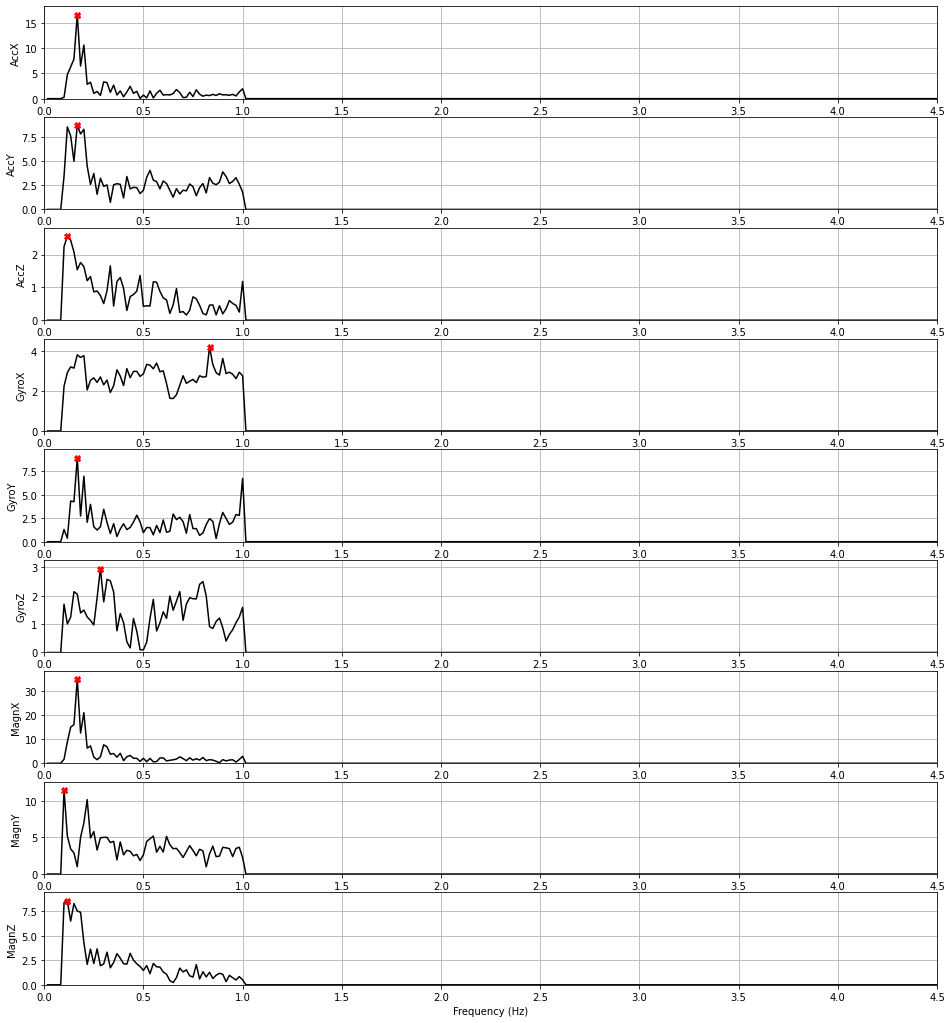

In [15]:
f_low_cut = 0.1
f_high_cut = 1

peak_freq = []

fig, axs = plt.subplots(9,1, figsize = (16,18))

for i, ax in enumerate(axs.flat): 
    
    
    #### Filtering frequencies
    _d = np.array(absolute.iloc[:,i])
    _mask = np.where(np.abs(frequency) < f_low_cut)
    _d[_mask] = 0
    _mask = np.where(np.abs(frequency) > f_high_cut)
    _d[_mask] = 0

    
    # Finding freq. with peak power
    peak_freq.append(frequency[_d.argmax()])
        
    ax.plot(frequency, _d , color='black')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(absolute.columns[i])
    ax.grid()
    
    ax.set_xlim([0,4.5])
    ax.set_ylim([0, (_d[_d.argmax()])*1.1])
    ax.plot(frequency[_d.argmax()], _d[_d.argmax()], 'X', color='r')

The highest peaked value is the value that affects the function the most after the inverse Fourier transform. Therefore, we chose AccX and MagnZ. When we look at the images, the highest peaks are here.

In [16]:
F = np.array(np.unique(peak_freq , return_counts=True))[0,-2:]
HR = F.max()
RR = F.min()
print(f'HR frequency is {HR:.2f} Hz, which is equal to {HR*60:.2f} beats per minute.')
print(f'RR frequency is {RR:.2f} Hz, which is equal to {RR*60:.2f} breath per minute.')

HR frequency is 0.83 Hz, which is equal to 50.00 beats per minute.
RR frequency is 0.28 Hz, which is equal to 17.00 breath per minute.


In [17]:
normalized_df['AccX']

0       -0.017022
1       -0.018762
2       -0.017854
3       -0.023049
4       -0.044926
           ...   
11995   -0.001321
11996   -0.012308
11997   -0.002837
11998    0.006943
11999   -0.014772
Name: AccX, Length: 12000, dtype: float64

Filter

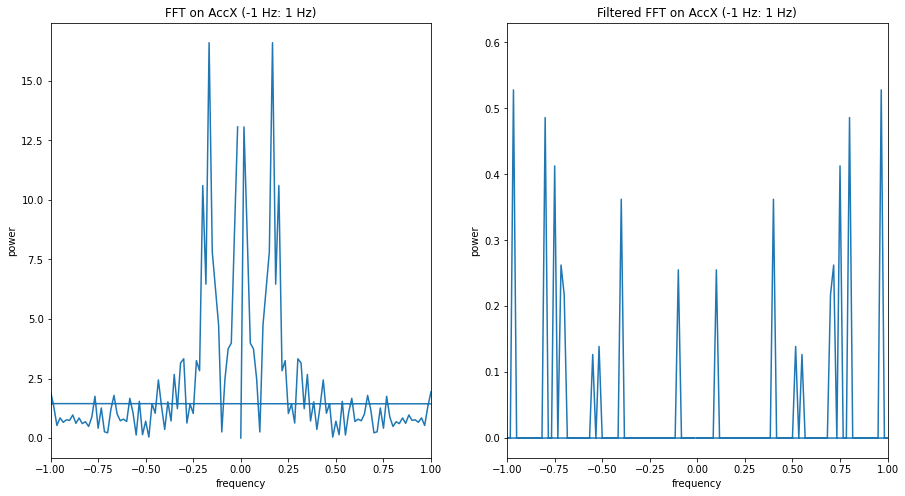

In [18]:
df_accx = normalized_df['AccX'].to_numpy()
df_accx -= np.mean(df_accx)
df_accx_fft = fftpack.fft(df_accx)
power = np.abs(df_accx_fft)
freq = fftpack.fftfreq(df_accx.size, d=1/200)

x1,x2 = 0.1,0.6
filter_fft = np.where((np.abs(df_accx_fft)<x1) | (np.abs(df_accx_fft) >x2))
df_accx_fft[filter_fft] = 0

fig, ax = plt.subplots(1,2,figsize = (15,8))
ax[0].plot(freq,power)
ax[0].set_xlim(-1,1)
ax[0].set(xlabel="frequency", ylabel="power",title="FFT on AccX (-1 Hz: 1 Hz)")
ax[1].plot(freq,np.abs(df_accx_fft))
ax[1].set_xlim(-1,1)
ax[1].set(xlabel="frequency", ylabel="power",title="Filtered FFT on AccX (-1 Hz: 1 Hz)")
plt.show()

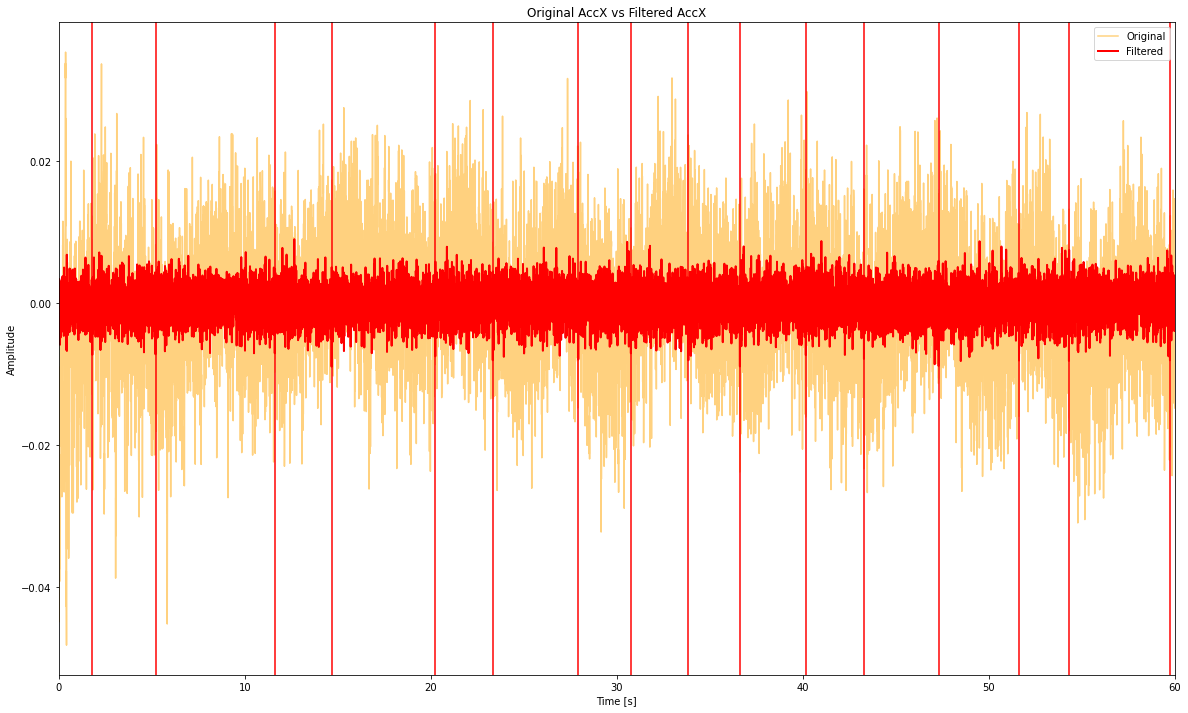

In [19]:
filtered_sig = fftpack.ifft(df_accx_fft)
filtered_sig = np.real(filtered_sig)

plt.figure(figsize=(20, 12))
plt.plot(limits, normalized_df['AccX'], alpha=0.5, color='orange', label='Original')
plt.plot(limits, filtered_sig, linewidth=2, color='r', label='Filtered')

## Find minima of the filtered signal and plot them with a red line
idx_minima = signal.argrelextrema(filtered_sig, np.less, order = 500)
for i in idx_minima[0]:
    plt.axvline(limits[i], color = 'r')
    
plt.xlabel('Time [s]')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(limits[0],limits[-1])
plt.title('Original AccX vs Filtered AccX')
plt.legend(loc='best')
plt.show()

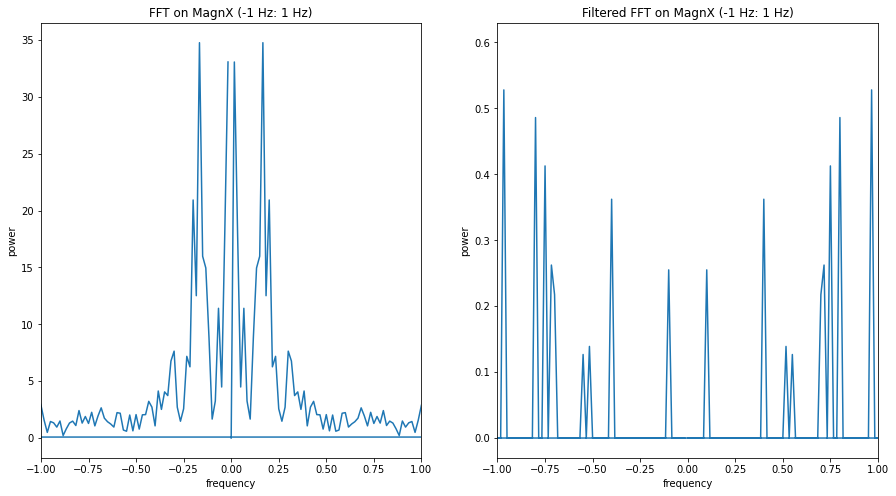

In [20]:
df_magnx = normalized_df['MagnX'].to_numpy()
df_magnx -= np.mean(df_magnx)
df_magnx_fft = fftpack.fft(df_magnx)
power = np.abs(df_magnx_fft)
freq = fftpack.fftfreq(df_magnx.size, d=1/200)

x1,x2 = 0.1,0.6
filter_fft = np.where((np.abs(df_magnx_fft)<x1) | (np.abs(df_magnx_fft) >x2))
df_magnx_fft[filter_fft] = 0

fig, ax = plt.subplots(1,2,figsize = (15,8))
ax[0].plot(freq,power)
ax[0].set_xlim(-1,1)
ax[0].set(xlabel="frequency", ylabel="power",title="FFT on MagnX (-1 Hz: 1 Hz)")
ax[1].plot(freq,np.abs(df_accx_fft))
ax[1].set_xlim(-1,1)
ax[1].set(xlabel="frequency", ylabel="power",title="Filtered FFT on MagnX (-1 Hz: 1 Hz)")
plt.show()

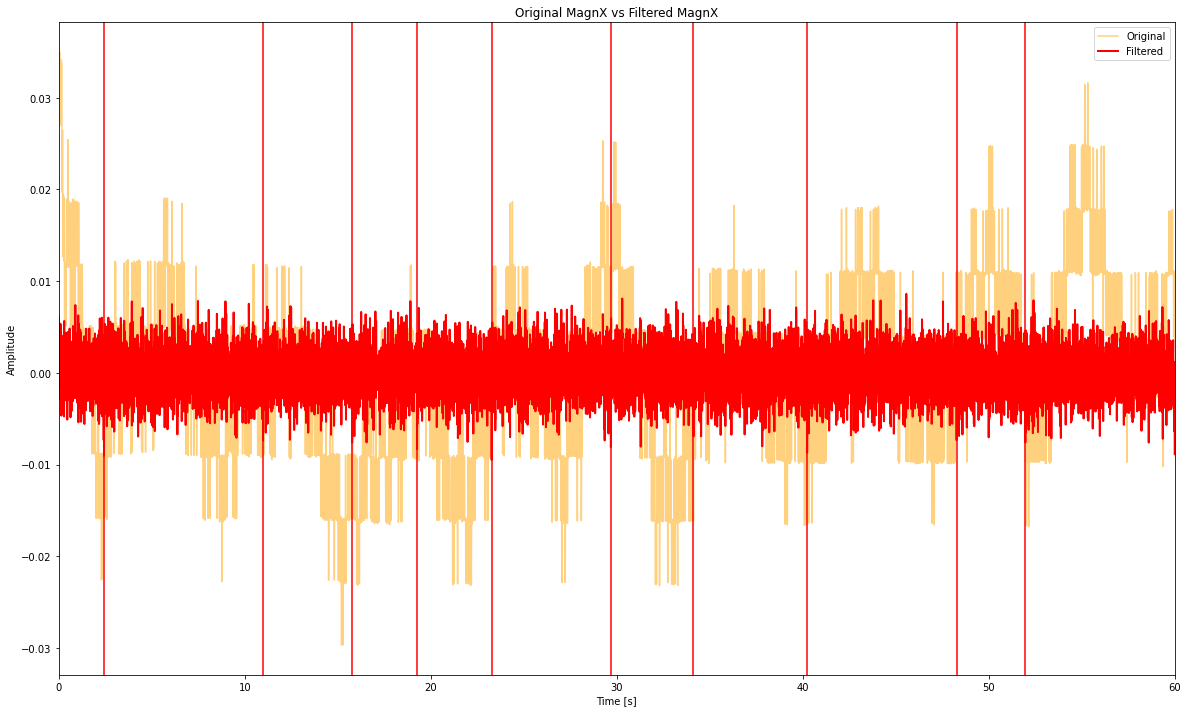

In [21]:
filtered_sig = fftpack.ifft(df_magnx_fft)
filtered_sig = np.real(filtered_sig)

plt.figure(figsize=(20, 12))
plt.plot(limits, normalized_df['MagnX'], alpha=0.5, color='orange', label='Original')
plt.plot(limits, filtered_sig, linewidth=2, color='r', label='Filtered')

## Find minima of the filtered signal and plot them with a red line
idx_minima = signal.argrelextrema(filtered_sig, np.less, order = 500)
for i in idx_minima[0]:
    plt.axvline(limits[i], color = 'r')
    
plt.xlabel('Time [s]')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(limits[0],limits[-1])
plt.title('Original MagnX vs Filtered MagnX')
plt.legend(loc='best')
plt.show()

Respiratory rate per minute (RPM)

Duration of the dataset: 60 seconds
Breaths in 60 seconds:  10


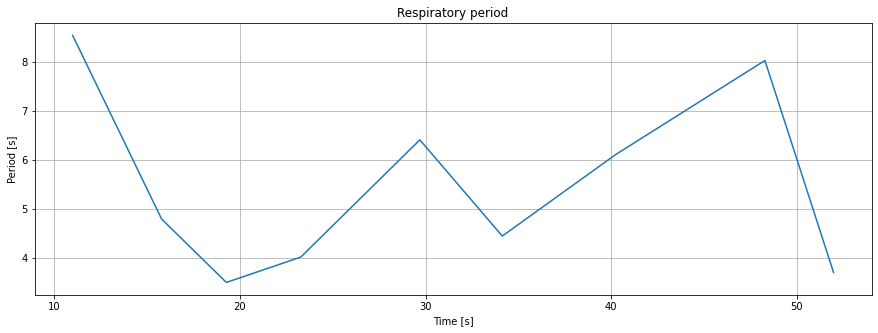

In [22]:
total_breaths = len(idx_minima[0])

print('Duration of the dataset: 60 seconds')
print('Breaths in 60 seconds: ',total_breaths)

gaps = []

for i in idx_minima[0]:
    gaps.append(limits[i])
    
periods_diff = []

for i in range(len(gaps)):
    if(i>0):
        periods_diff.append(gaps[i]-gaps[i-1])
        
#plot the period vs time
plt.figure(figsize=(15,5))
plt.plot(gaps[1:],periods_diff)
plt.title("Respiratory period")
plt.xlabel('Time [s]')
plt.ylabel('Period [s]')
plt.grid()
plt.show()

Respiratory rate variability (RRV)

Mean RRV (intended as period variability) calculated on whole dataset: 2.24 s


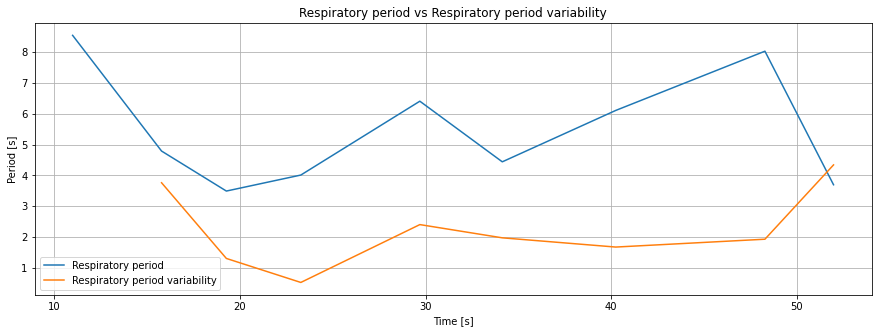

In [23]:
from scipy.signal.waveforms import gausspulse
#plot the period variability vs time
periods_diff_diff = []
for i in range(len(periods_diff)):
    if(i>0):
        periods_diff_diff.append(abs(periods_diff[i]-periods_diff[i-1]))
        
mean_rrv = np.mean(periods_diff_diff) 
print("Mean RRV (intended as period variability) calculated on whole dataset:", round(mean_rrv,2), "s")

plt.figure(figsize=(15,5))
plt.plot(gaps[1:],periods_diff,label='Respiratory period')
plt.title("Respiratory period vs Respiratory period variability")
plt.plot(gaps[2:],periods_diff_diff,label='Respiratory period variability')
plt.xlabel('Time [s]')
plt.ylabel('Period [s]')
plt.grid()
plt.legend()
plt.show()

periods_diff = []

It does not follow a particular distribution.

# Analysis for 4_chest_sweater.txt

In [24]:
file = "4_Chest_sweater.txt"  #Actual File
data = pd.read_csv(file, delimiter="\t") #read csv
data

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,100,1555414552,687.836,380.823,580.354,-7.926829,8.048780,0.975610,-592,122,-113,0.788006,0.002899,-0.432874,-0.437788
1,5,100,1555414552,-812.703,-108.946,726.876,-11.707320,-81.829270,8.780488,125,60,-128,0.183978,-0.428877,0.002594,0.884426
2,5,100,1555414552,-812.520,-108.824,733.952,-37.073170,-145.487800,14.756100,123,59,-136,0.128994,-0.427229,0.000702,0.894894
3,5,100,1555414552,-787.144,-45.628,616.954,-56.341460,-174.634200,23.048780,118,58,-145,0.113618,-0.421033,-0.001770,0.899899
4,5,100,1555414552,-800.259,-137.433,411.689,-1.097561,37.073170,1.341463,113,57,-157,0.107202,-0.424787,-0.001251,0.898923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14933,5,100,1555415471,-890.722,-81.008,446.764,-2.682927,2.926829,0.365854,144,47,-50,0.017279,0.534410,0.040437,-0.844081
14934,5,100,1555415471,-885.964,-76.006,459.025,-3.902439,3.292683,0.365854,146,45,-51,0.016416,0.535050,0.041231,-0.843654
14935,5,100,1555415471,-879.681,-77.714,475.068,-3.048780,2.804878,0.365854,144,46,-54,0.015920,0.534349,0.041780,-0.844081
14936,5,100,1555415471,-894.992,-76.311,502.701,0.121951,1.463415,0.609756,144,45,-53,0.015192,0.531663,0.041749,-0.845790


# Dropping unnecessary columns

In [25]:
#dropping the columns which wont be used anymore (qw,qi,qj,qk) 

df2 = pd.DataFrame(data)
df2.drop(df2.columns[[12,13,14,15]],inplace=True,axis=1) 
df2

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,5,100,1555414552,687.836,380.823,580.354,-7.926829,8.048780,0.975610,-592,122,-113
1,5,100,1555414552,-812.703,-108.946,726.876,-11.707320,-81.829270,8.780488,125,60,-128
2,5,100,1555414552,-812.520,-108.824,733.952,-37.073170,-145.487800,14.756100,123,59,-136
3,5,100,1555414552,-787.144,-45.628,616.954,-56.341460,-174.634200,23.048780,118,58,-145
4,5,100,1555414552,-800.259,-137.433,411.689,-1.097561,37.073170,1.341463,113,57,-157
...,...,...,...,...,...,...,...,...,...,...,...,...
14933,5,100,1555415471,-890.722,-81.008,446.764,-2.682927,2.926829,0.365854,144,47,-50
14934,5,100,1555415471,-885.964,-76.006,459.025,-3.902439,3.292683,0.365854,146,45,-51
14935,5,100,1555415471,-879.681,-77.714,475.068,-3.048780,2.804878,0.365854,144,46,-54
14936,5,100,1555415471,-894.992,-76.311,502.701,0.121951,1.463415,0.609756,144,45,-53


# Plot selected data wrt the time window

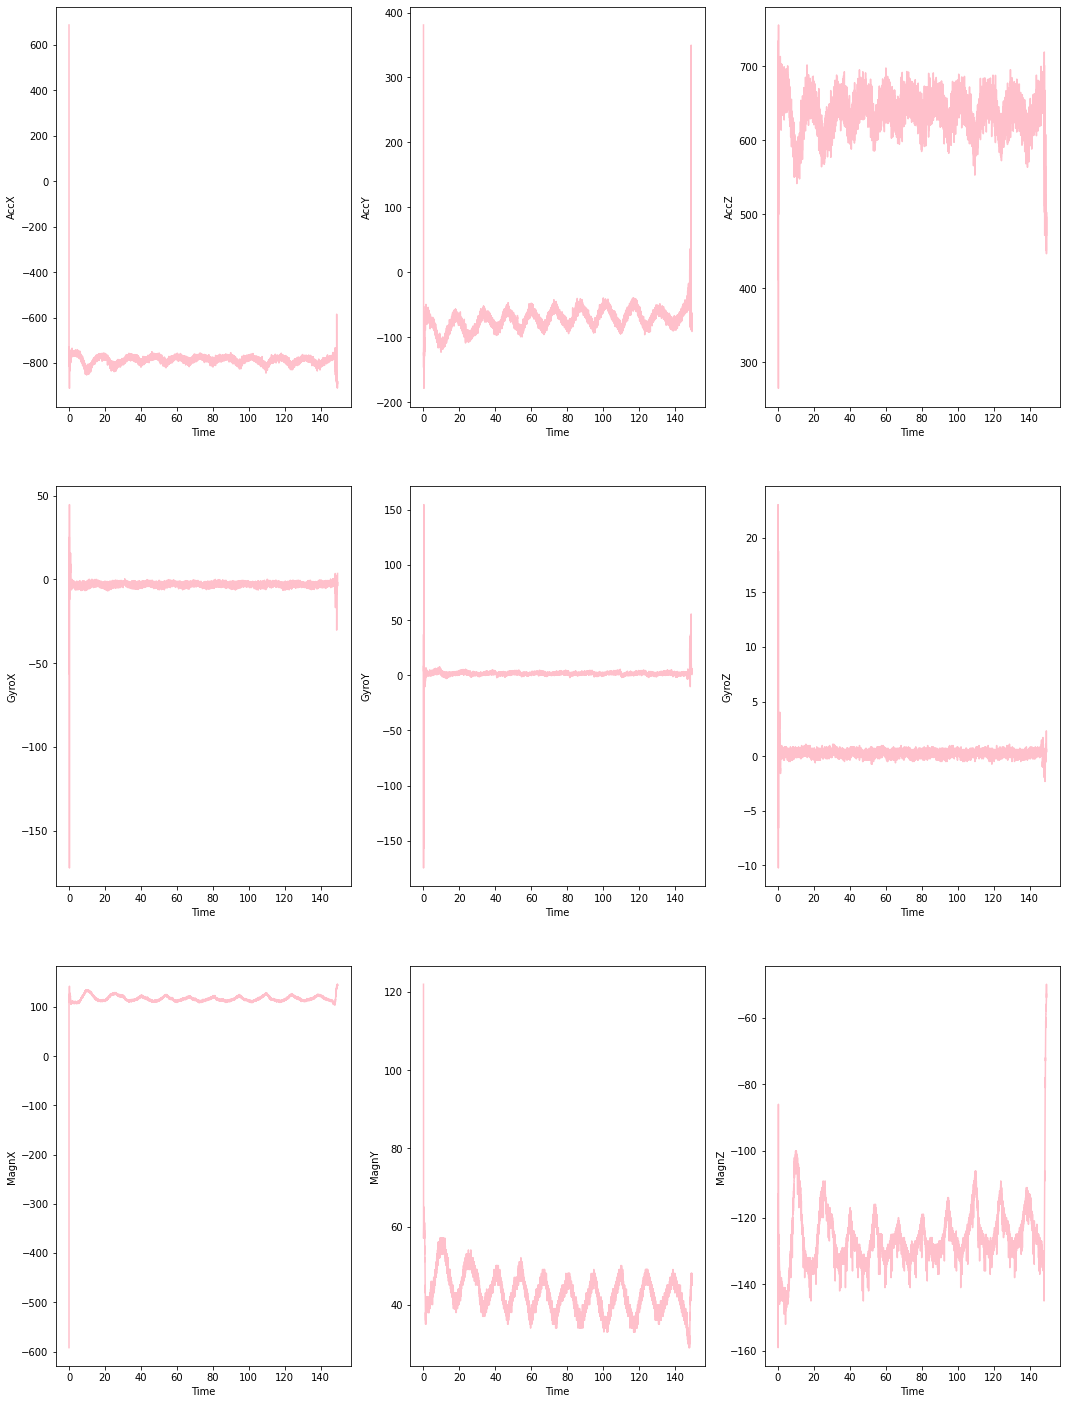

In [26]:
#In the following cells, we wanted to see some plots to explore the data in details, 
#based on the variables AccX,AccY and AccZ which is the linear acceleration

sampling_frequency = 100
limits = np.linspace(0, df2.shape[0]/sampling_frequency,df2.shape[0])  #starts from 0, goes untill stop number, number of samples to generate is df.shape[0]

labels = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']
fig, axes = plt.subplots(3, 3, figsize = (18, 25))
for i ,axs in enumerate(axes.flat):
    axs.plot(limits, df2[labels[i]], color = 'pink')
    axs.set_xlabel('Time')
    axs.set_ylabel(labels[i])

# Choosing a proper time window


In [27]:
min_time = 0 #for the first 0 seconds  
max_time = 7000 #for the 70th time frame  70*100
df2 = df2.iloc[min_time:max_time].copy()
df2


,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,5,100,1555414552,687.836,380.823,580.354,-7.926829,8.048780,0.975610,-592,122,-113
1,5,100,1555414552,-812.703,-108.946,726.876,-11.707320,-81.829270,8.780488,125,60,-128
2,5,100,1555414552,-812.520,-108.824,733.952,-37.073170,-145.487800,14.756100,123,59,-136
3,5,100,1555414552,-787.144,-45.628,616.954,-56.341460,-174.634200,23.048780,118,58,-145
4,5,100,1555414552,-800.259,-137.433,411.689,-1.097561,37.073170,1.341463,113,57,-157
...,...,...,...,...,...,...,...,...,...,...,...,...
6995,5,100,1555415393,-775.798,-63.196,665.998,-1.463415,0.365854,0.121951,115,44,-128
6996,5,100,1555415393,-791.414,-67.649,654.530,-0.365854,0.000000,0.487805,115,41,-128
6997,5,100,1555415393,-789.096,-80.154,618.540,-1.585366,1.097561,0.609756,114,42,-127
6998,5,100,1555415393,-782.081,-74.786,626.653,-2.195122,1.463415,0.365854,115,43,-128


# Calibrating linear acceleration, angular velocity and magnetic field

In [28]:
accelometer_calibration = np.array([[1.002982,9.415505E-05,0.00434674],
                    [9.04459E-05,1.002731,-0.001444198],
                    [0.004346536,-0.001444751,1.030587]])
transpose_a = accelometer_calibration.T
accelometer_offset = np.array([3.602701,-20.96658,54.97186])

gyroscope_offset = np.array([-2.804399,1.793105,0.3411708])

magneticfield_calibration = np.array([[1.013437,-0.04728858,-0.001861475],
                   [-0.04728862,1.004832,0.008222118],
                   [-0.001861605,0.008221965,0.9439077]])

transpose_m = magneticfield_calibration
magneticfield_offset = np.array([-150.4098,74.62431,630.9805])




df2[['GyroX','GyroY','GyroZ']] = df2[['GyroX','GyroY','GyroZ']] + gyroscope_offset
df2[['AccX','AccY','AccZ']] = np.dot(df2[['AccX','AccY','AccZ']], transpose_a) + accelometer_offset
df2[['MagnX','MagnY','MagnZ']] = np.dot(df2[['MagnX','MagnY','MagnZ']], transpose_m) + magneticfield_offset
df2



,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,5,100,1555414552,696.048332,360.120513,655.516657,-10.731228,9.841885,1.316781,-755.923354,224.279571,526.424021
1,5,100,1555414552,-808.374496,-131.333370,800.705773,-14.511719,-80.036165,9.121659,-26.329207,127.950746,510.420957
2,5,100,1555414552,-808.160181,-131.221239,807.998826,-39.877569,-143.694695,15.097271,-28.293899,126.974715,502.865196
3,5,100,1555414552,-783.211120,-67.681388,687.441203,-59.145859,-172.841095,23.389951,-33.297041,126.132329,494.371112
4,5,100,1555414552,-797.266106,-159.441850,475.973393,-3.901960,38.866275,1.682634,-38.294598,125.265276,483.045305
...,...,...,...,...,...,...,...,...,...,...,...,...
6995,5,100,1555415393,-771.619759,-85.367169,738.060009,-4.267814,2.158959,0.463122,-35.706959,112.346320,510.308018
6996,5,100,1555415393,-787.332593,-89.817180,726.179796,-3.170253,1.793105,0.828976,-35.565093,109.331824,510.283352
6997,5,100,1555415393,-785.165298,-102.304145,689.117111,-4.389765,2.890666,0.950927,-36.627680,110.392166,511.237343
6998,5,100,1555415393,-778.093608,-96.932568,697.500999,-4.999521,3.256520,0.707024,-35.659670,111.341488,510.299796


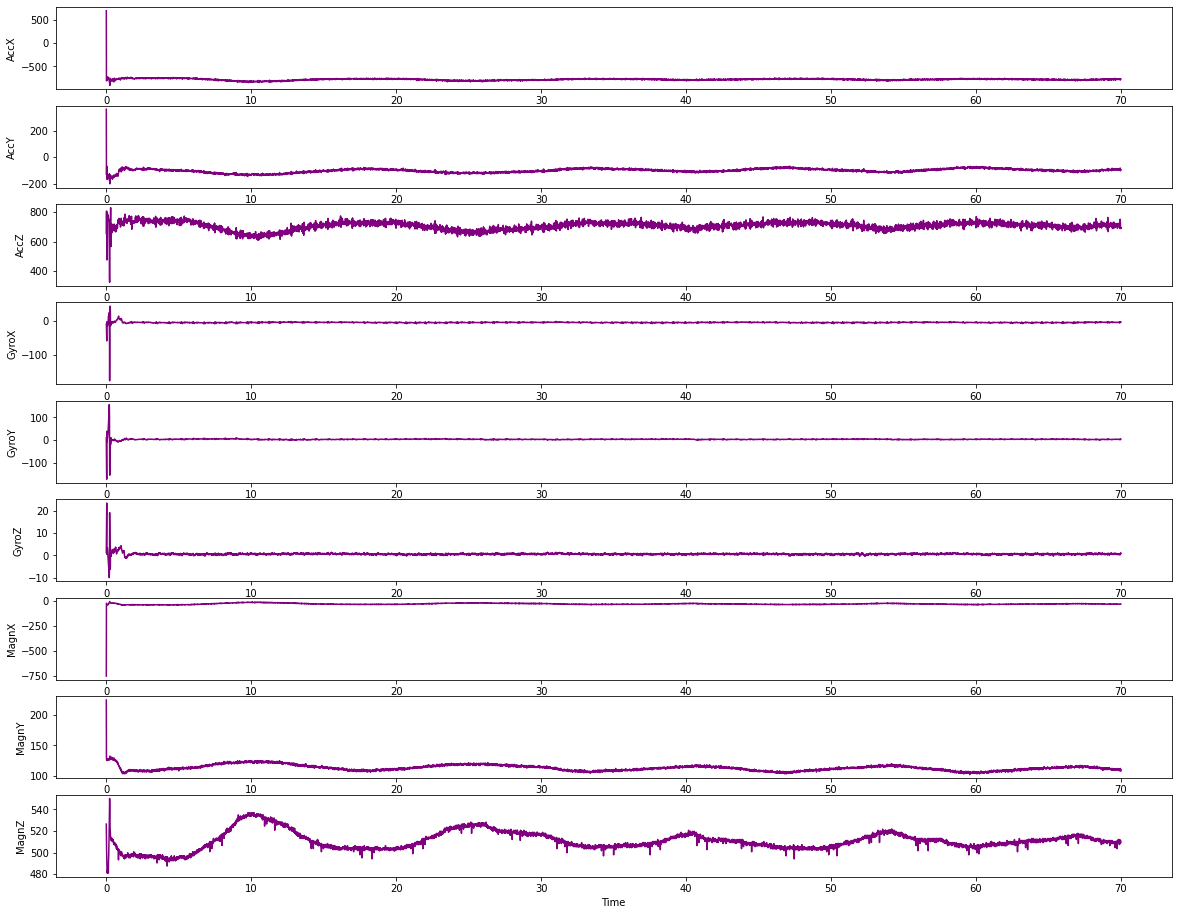

In [29]:
fig, axes = plt.subplots(9, 1, figsize = (20, 16))
limits = np.linspace(0,df2.shape[0]/sampling_frequency,df2.shape[0])
for i ,axs in enumerate(axes.flat):
    axs.plot(limits, df2[labels[i]], color = 'purple')
    axs.set_xlabel('Time')
    axs.set_ylabel(labels[i])

# Time and Frequency Analysis

In [ ]:
# Statistical Analysis

In [30]:
df2.drop(df2.columns[[0,1,2]],inplace=True,axis=1)
df2.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,-781.125368,-101.849421,707.450434,-5.576646,3.319115,0.648401,-33.198671,113.225776,510.880091
std,24.902340,15.513338,27.718855,2.825867,6.025490,0.615069,10.314981,4.867922,8.371977
min,-907.460490,-201.247270,324.476430,-174.999499,-172.841095,-9.902729,-755.923354,102.304179,481.169435
25%,-791.890863,-110.685812,692.399447,-6.097082,2.646764,0.463122,-37.440793,109.407914,505.559314
50%,-779.011414,-100.749635,711.180117,-5.609277,3.256520,0.585073,-33.974430,113.186663,510.281490
75%,-769.141603,-90.997508,725.966132,-5.121472,3.988227,0.828976,-29.775184,116.100403,515.053775
max,696.048332,360.120513,830.521399,41.829751,156.549205,23.389951,-9.273542,224.279571,550.049880


           AccX      AccY      AccZ  ...     MagnX     MagnY     MagnZ
AccX   1.000000  0.731474  0.535443  ... -0.939958 -0.315877 -0.617600
AccY   0.731474  1.000000  0.652901  ... -0.717989 -0.745499 -0.631604
AccZ   0.535443  0.652901  1.000000  ... -0.438250 -0.693512 -0.829790
GyroX  0.002278 -0.049638  0.147986  ...  0.012129  0.010465 -0.035288
GyroY  0.044696 -0.006248 -0.025121  ... -0.027739 -0.003318 -0.031416
GyroZ -0.008372 -0.014615 -0.047210  ...  0.005309  0.053634  0.004664
MagnX -0.939958 -0.717989 -0.438250  ...  1.000000  0.223317  0.498077
MagnY -0.315877 -0.745499 -0.693512  ...  0.223317  1.000000  0.708208
MagnZ -0.617600 -0.631604 -0.829790  ...  0.498077  0.708208  1.000000

[9 rows x 9 columns]


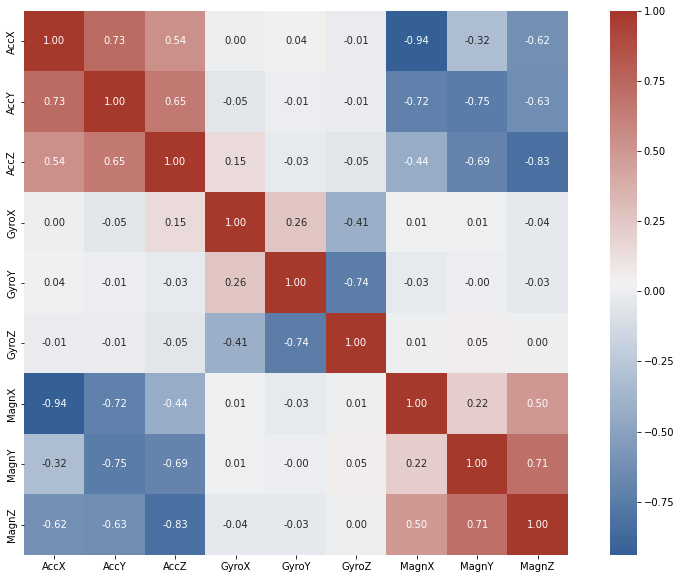

In [31]:
#We wanted to find a correlation matrix in order to see the correlation among the variables. 
#Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize the data as a diagnostic for adcanced analyses
def plot_correlation_matrix(data):
    #this correlation matrix has coefficients ranges from 1 to -1, while -1 refers to negative correlation and +1 perfect positive correllation.
    plt.subplots(figsize=(15, 10))
    corr_matrix = data.corr() #Compute pairwise correlation of columns, excluding NA/null values
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True) #custom diverging palette with red blue and white to use it in the heatmap
    
    sns.heatmap(corr_matrix, annot=True, 
                fmt='.2f', square=True, cmap=cmap) #heatmap: a graphical representation of data that uses a system of color-coding to represent different values.
    return corr_matrix,corr_matrix

corr_matrix,correlation_coefficients = plot_correlation_matrix(df2)
print(correlation_coefficients)


# Fourier Analysis

In [32]:
df2.columns

Index(['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY',
       'MagnZ'],
      dtype='object')

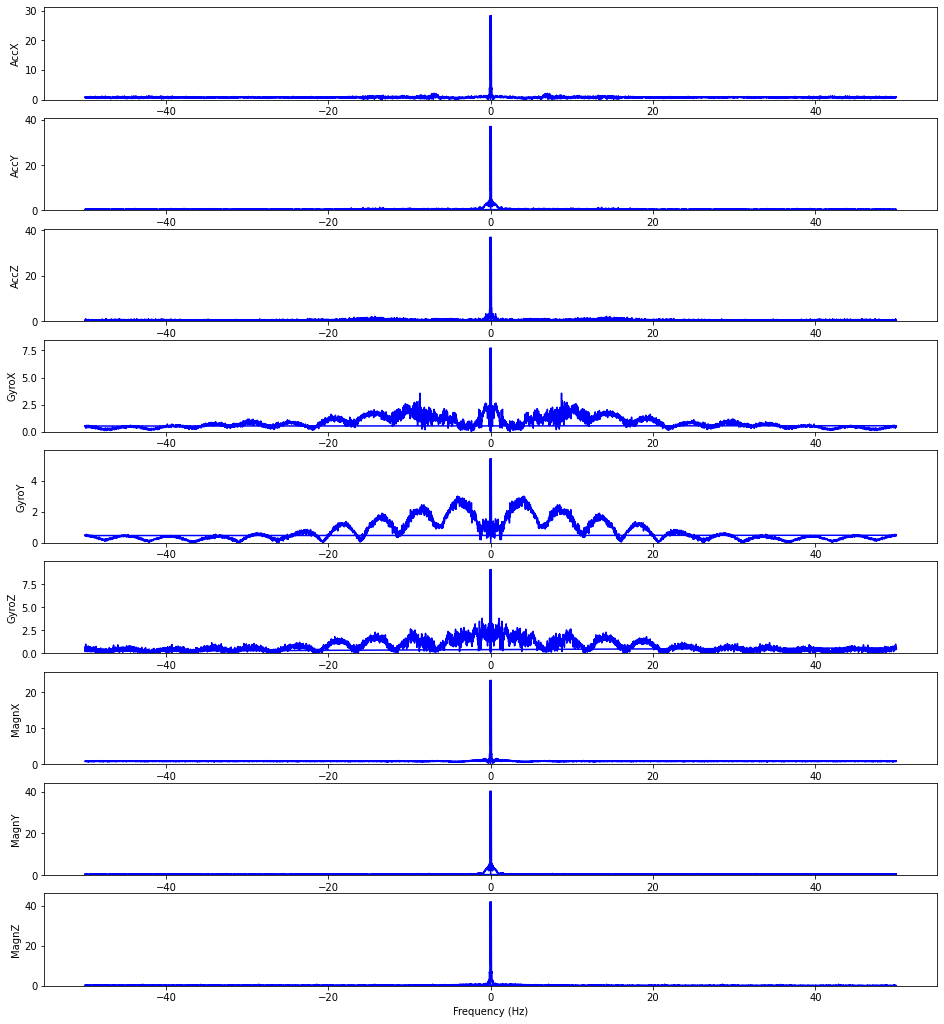

In [33]:
from scipy import fft, signal, interpolate
from sklearn import preprocessing
#normalizing the data:
df_mean = df2.apply(np.mean)
df2 = df2- df_mean

#Subtracting the mean: (detrending the signal)
"""Generally, for signal analysis the FFT is used on signals of infinite 
length.  So, when you chop up your signal into finite-length segments, 
you are making an approximation.  Detrending the signal makes this 
approximation better"""



normalized_df = pd.DataFrame(preprocessing.normalize(df2, axis=0), columns=df2.columns)


fourier = normalized_df.apply(np.fft.fft)
absolute = fourier.apply(np.abs)

frequency = fft.fftfreq(absolute.shape[0] , d=1/100)


fig, axs = plt.subplots(9,1, figsize = (16,18))
for i, ax in enumerate(axs.flat):   
    az = np.array(absolute.iloc[:,i])
    find_peaks, _property = signal.find_peaks(az, distance=100)
    
        
    ax.set_ylim([0, az[find_peaks].max()*1.1])
    ax.plot(frequency, az, color='blue')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(absolute.columns[i])


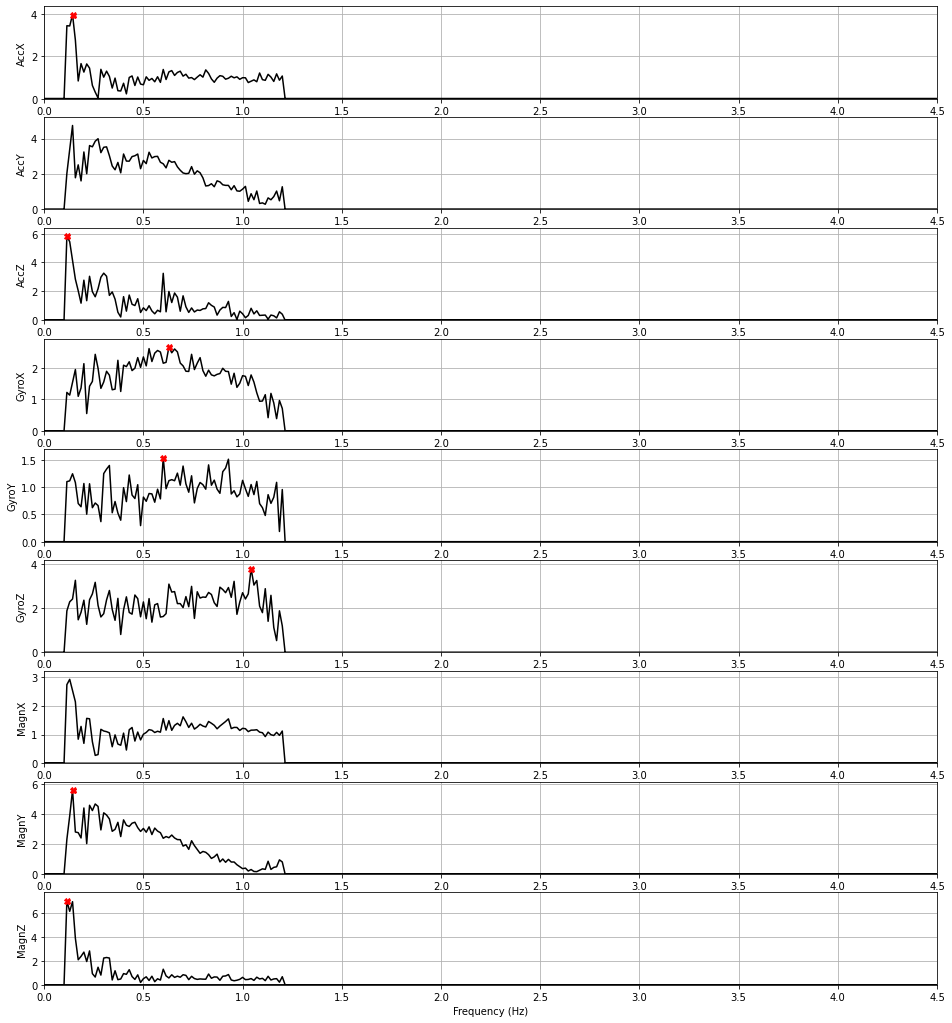

In [34]:
f_low_cut = 0.1
f_high_cut = 1.2

peak_freq = []

fig, axs = plt.subplots(9,1, figsize = (16,18))

for i, ax in enumerate(axs.flat): 
    
    
    #### Filtering frequencies
    _d = np.array(absolute.iloc[:,i])
    _mask = np.where(np.abs(frequency) < f_low_cut)
    _d[_mask] = 0
    _mask = np.where(np.abs(frequency) > f_high_cut)
    _d[_mask] = 0

    
    # Finding freq. with peak power
    peak_freq.append(frequency[_d.argmax()])
        
    ax.plot(frequency, _d , color='black')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(absolute.columns[i])
    ax.grid()
    
    ax.set_xlim([0,4.5])
    ax.set_ylim([0, (_d[_d.argmax()])*1.1])
    ax.plot(frequency[_d.argmax()], _d[_d.argmax()], 'X', color='r')

The value with the highest peak is the value that affects the function the most after the inverse fourier transform. That's why we chose AccX and MagnX. When we look at the images, the highest peaks are here.
We chose AccX and MagnX because they have the highest peaks.

In [35]:
normalized_df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,0.709044,0.355951,-0.022395,-0.021803,0.012940,0.012989,-0.837503,0.272692,0.022193
1,-0.013080,-0.022718,0.040214,-0.037794,-0.165357,0.164668,0.007960,0.036157,-0.000656
2,-0.012977,-0.022631,0.043359,-0.145090,-0.291640,0.280797,0.005684,0.033760,-0.011443
3,-0.001001,0.026327,-0.008629,-0.226593,-0.349460,0.441955,-0.000114,0.031692,-0.023571
4,-0.007748,-0.044375,-0.099819,0.007084,0.070517,0.020099,-0.005905,0.029563,-0.039741
...,...,...,...,...,...,...,...,...,...
6995,0.004563,0.012700,0.013200,0.005536,-0.002301,-0.003601,-0.002907,-0.002159,-0.000817
6996,-0.002979,0.009271,0.008077,0.010179,-0.003027,0.003509,-0.002742,-0.009562,-0.000852
6997,-0.001939,-0.000350,-0.007906,0.005020,-0.000850,0.005879,-0.003974,-0.006958,0.000510
6998,0.001455,0.003788,-0.004290,0.002441,-0.000124,0.001139,-0.002852,-0.004627,-0.000829


In [36]:
absolute = absolute.drop(absolute[frequency <= 0].index)
frequency = frequency[np.where(frequency> 0)]

In [37]:
F = np.array(np.unique(peak_freq , return_counts=True))[0,-2:]
HR = F.max()
RR = F.min()
print(f'HR frequency is {HR:.2f} Hz, which is equal to {HR*60:.2f} beats per minute.')
print(f'RR frequency is {RR:.2f} Hz, which is equal to {RR*60:.2f} breath per minute.')

HR frequency is 1.04 Hz, which is equal to 62.57 beats per minute.
RR frequency is 0.63 Hz, which is equal to 37.71 breath per minute.


In [38]:
normalized_df['AccX']

0       0.709044
1      -0.013080
2      -0.012977
3      -0.001001
4      -0.007748
          ...   
6995    0.004563
6996   -0.002979
6997   -0.001939
6998    0.001455
6999    0.004733
Name: AccX, Length: 7000, dtype: float64

#Filter

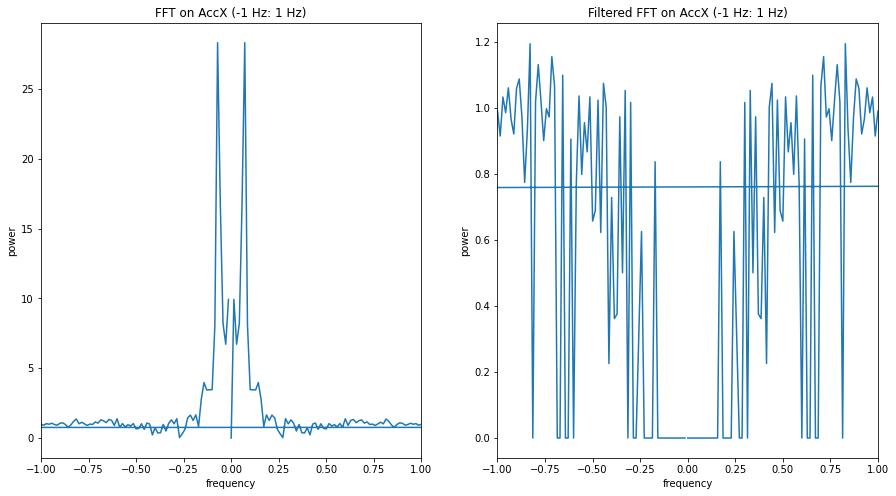

In [39]:
df_accx = normalized_df['AccX'].to_numpy()
df_accx -= np.mean(df_accx)
df_accx_fft = fftpack.fft(df_accx)
power = np.abs(df_accx_fft)
freq = fftpack.fftfreq(df_accx.size, d=1/100)

x1,x2 = 0.1,1.2
filter_fft = np.where((np.abs(df_accx_fft)<x1) | (np.abs(df_accx_fft) >x2))
df_accx_fft[filter_fft] = 0

fig, ax = plt.subplots(1,2,figsize = (15,8))
ax[0].plot(freq,power)
ax[0].set_xlim(-1,1)
ax[0].set(xlabel="frequency", ylabel="power",title="FFT on AccX (-1 Hz: 1 Hz)")
ax[1].plot(freq,np.abs(df_accx_fft))
ax[1].set_xlim(-1,1)
ax[1].set(xlabel="frequency", ylabel="power",title="Filtered FFT on AccX (-1 Hz: 1 Hz)")
plt.show()

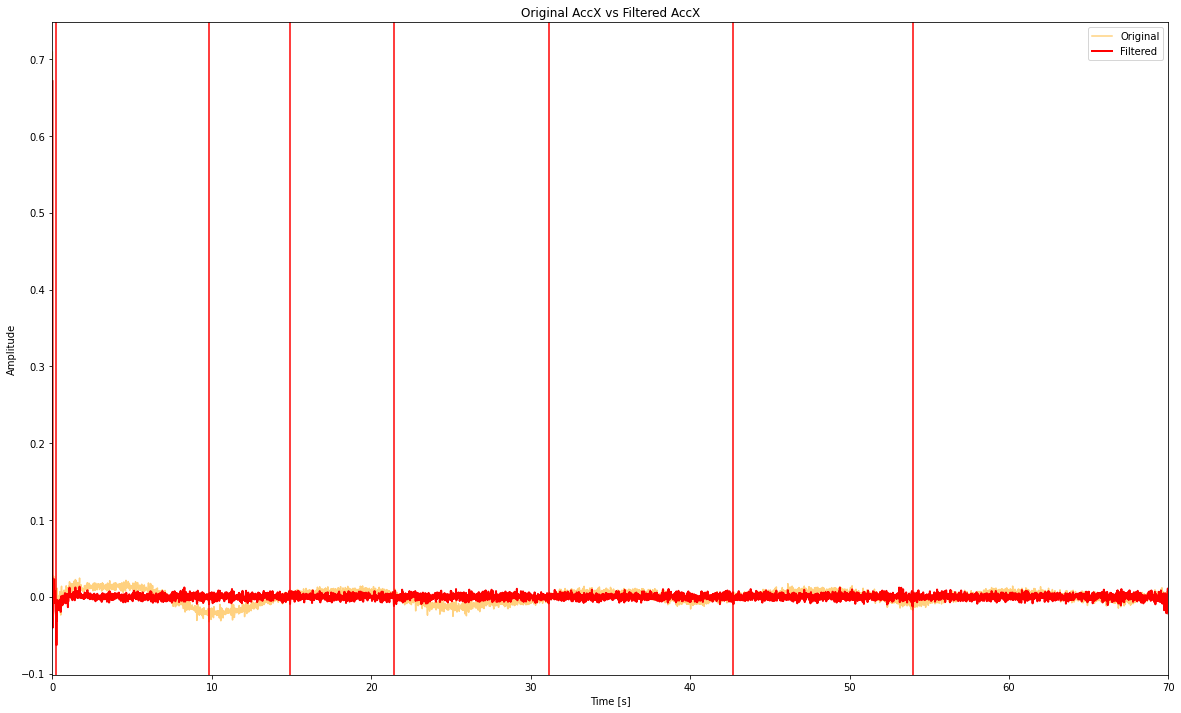

In [40]:
filtered_sig = fftpack.ifft(df_accx_fft)
filtered_sig = np.real(filtered_sig)

plt.figure(figsize=(20, 12))
plt.plot(limits, normalized_df['AccX'], alpha=0.5, color='orange', label='Original')
plt.plot(limits, filtered_sig, linewidth=2, color='r', label='Filtered')

## Find minima of the filtered signal and plot them with a red line
idx_minima = signal.argrelextrema(filtered_sig, np.less, order = 500)
for i in idx_minima[0]:
    plt.axvline(limits[i], color = 'r')
    
plt.xlabel('Time [s]')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(limits[0],limits[-1])
plt.title('Original AccX vs Filtered AccX')
plt.legend(loc='best')
plt.show()

We tried filtering for GyrX and GyrZ, but we got the AccX and MagnX values again because they conflicted.

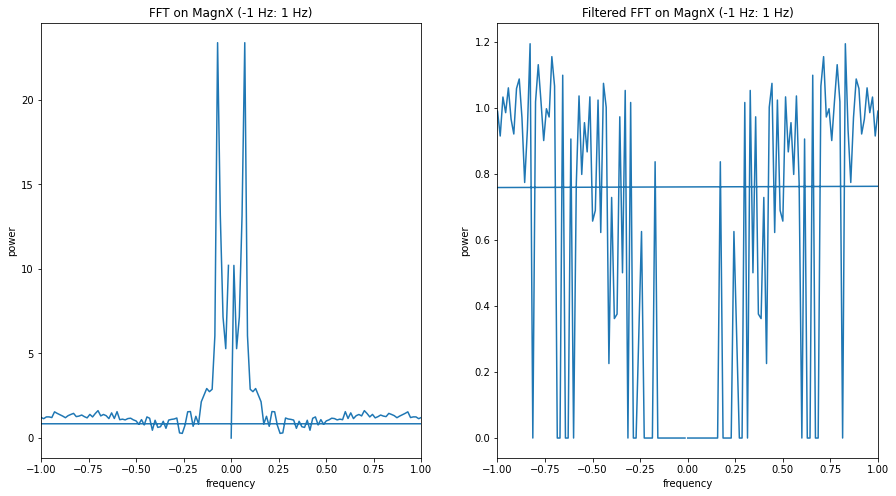

In [41]:
df_magnx = normalized_df['MagnX'].to_numpy()
df_magnx -= np.mean(df_magnx)
df_magnx_fft = fftpack.fft(df_magnx)
power = np.abs(df_magnx_fft)
freq = fftpack.fftfreq(df_magnx.size, d=1/100)

x1,x2 = 0.1,0.6
filter_fft = np.where((np.abs(df_magnx_fft)<x1) | (np.abs(df_magnx_fft) >x2))
df_magnx_fft[filter_fft] = 0

fig, ax = plt.subplots(1,2,figsize = (15,8))
ax[0].plot(freq,power)
ax[0].set_xlim(-1,1)
ax[0].set(xlabel="frequency", ylabel="power",title="FFT on MagnX (-1 Hz: 1 Hz)")
ax[1].plot(freq,np.abs(df_accx_fft))
ax[1].set_xlim(-1,1)
ax[1].set(xlabel="frequency", ylabel="power",title="Filtered FFT on MagnX (-1 Hz: 1 Hz)")
plt.show()

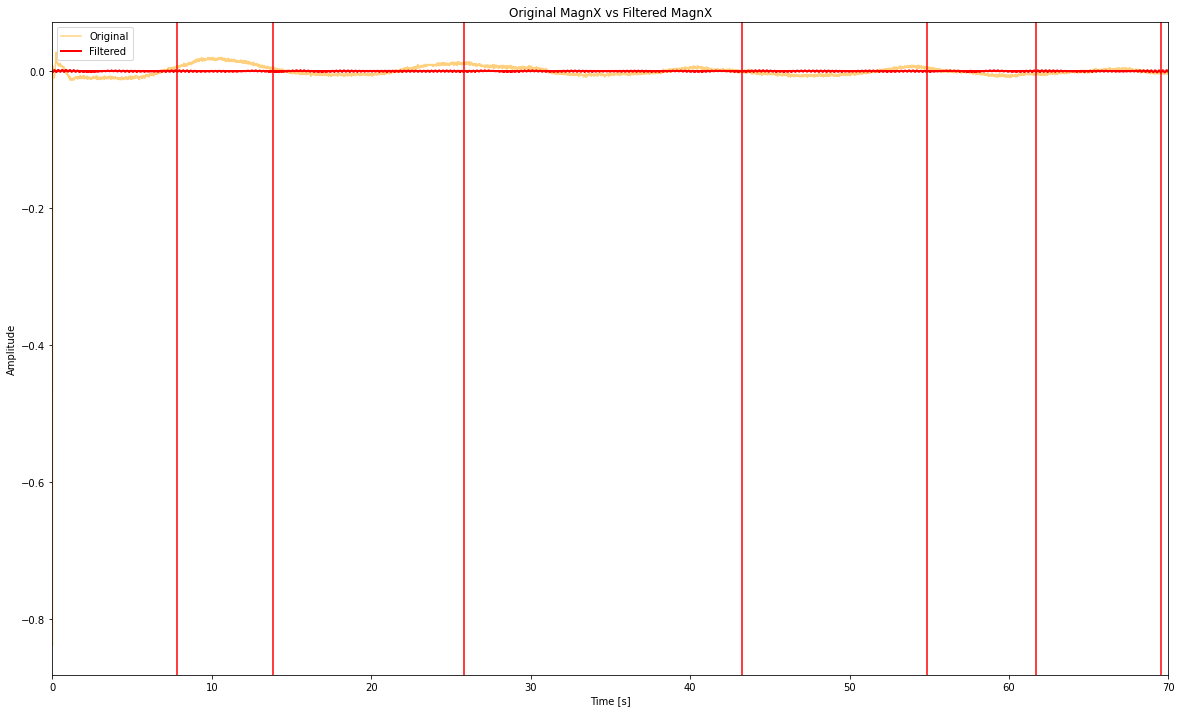

In [42]:
filtered_sig = fftpack.ifft(df_magnx_fft)
filtered_sig = np.real(filtered_sig)

plt.figure(figsize=(20, 12))
plt.plot(limits, normalized_df['MagnX'], alpha=0.5, color='orange', label='Original')
plt.plot(limits, filtered_sig, linewidth=2, color='r', label='Filtered')

## Find minima of the filtered signal and plot them with a red line
idx_minima = signal.argrelextrema(filtered_sig, np.less, order = 500)
for i in idx_minima[0]:
    plt.axvline(limits[i], color = 'r')
    
plt.xlabel('Time [s]')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(limits[0],limits[-1])
plt.title('Original MagnX vs Filtered MagnX')
plt.legend(loc='best')
plt.show()

# Respiratory rate per minute (RPM)

Duration of the dataset: 60 seconds
Breaths in 60 seconds:  7


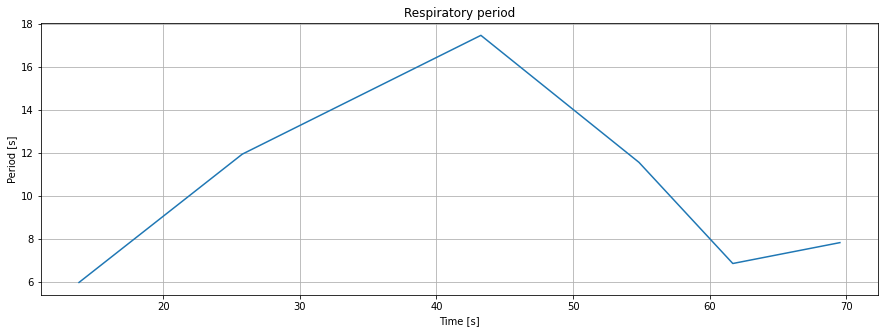

In [43]:
total_breaths = len(idx_minima[0])

print('Duration of the dataset: 60 seconds')
print('Breaths in 60 seconds: ',total_breaths)

gaps = []

for i in idx_minima[0]:
    gaps.append(limits[i])
    
periods_diff = []

for i in range(len(gaps)):
    if(i>0):
        periods_diff.append(gaps[i]-gaps[i-1])
        
#plot the period vs time
plt.figure(figsize=(15,5))
plt.plot(gaps[1:],periods_diff)
plt.title("Respiratory period")
plt.xlabel('Time [s]')
plt.ylabel('Period [s]')
plt.grid()
plt.show()

#Respiratory rate variability (RRV)

Mean RRV (intended as period variability) calculated on whole dataset: 4.61 s


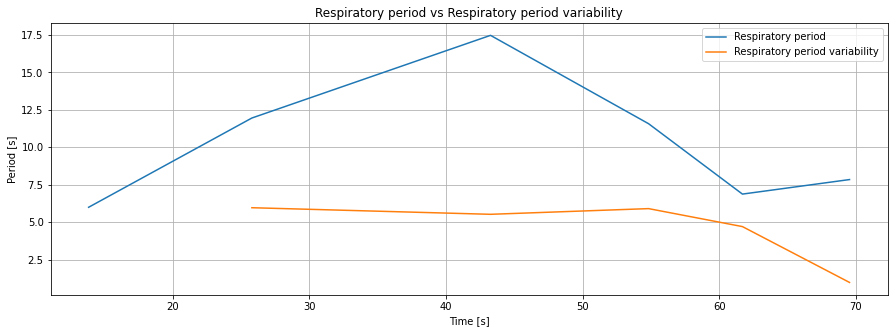

In [44]:
from scipy.signal.waveforms import gausspulse
#plot the period variability vs time
periods_diff_diff = []
for i in range(len(periods_diff)):
    if(i>0):
        periods_diff_diff.append(abs(periods_diff[i]-periods_diff[i-1]))
        
mean_rrv = np.mean(periods_diff_diff) 
print("Mean RRV (intended as period variability) calculated on whole dataset:", round(mean_rrv,2), "s")

plt.figure(figsize=(15,5))
plt.plot(gaps[1:],periods_diff,label='Respiratory period')
plt.title("Respiratory period vs Respiratory period variability")
plt.plot(gaps[2:],periods_diff_diff,label='Respiratory period variability')
plt.xlabel('Time [s]')
plt.ylabel('Period [s]')
plt.grid()
plt.legend()
plt.show()

periods_diff = []

It follows a particular distribution.

# Conclusion

First, we loaded the center_sternum.txt file and selected the columns that were meaningful and removed the others. We had them plotted to see the data in detail, based on the variables AccX, AccY, and AccZ, which are linear accelerations from 0 to the last number for each with the given sampling frequency. We chose an appropriate timing window. We chose windows to restrict places outside of the noisy ranges. This analysis influenced the selection procedure of the time window.

We calibrated the data because we needed to identify the deviations of the data used and correct the errors. Thus, the reliability of the measurement results was ensured as the accuracy of all the data in the measurement chain was finalized. After the noisy data we removed from the calibration, we poured the rest into the table. We plotted the range values.

In the second part we did time and frequency analysis. While doing the analysis of correlation coefficients, we did it with heat map because it looks much better and is easier for correlation analysis. As you can see, the correlation coefficient between GyroX, GyroY and GyroZ is very high. Fourier analysis was performed on the data. We used FFT for an infinitely long signal. When we divide our signal into parts of finite length, we have made an approximation of the signal trend. When we did the Fourier analysis, we first filtered the frequencies and then filtered the peak values. The highest peak value is the value that affects the function the most after the inverse Fourier transform. That's why we chose AccX and MagnZ. When we look at the images, the highest peaks are here.

We subtracted the frequency values ​​less than 0 for the time domain. Because we consider real time in the time domain, there cannot be a situation smaller than 0. We filtered AccX and the result of this allowed us to analyze the power values ​​more clearly. By performing the inverse Fourier transform, we graphically revealed the original and filtered signal together. If we look at the filtered Accx and the original, we see that the filtered signal has less amplitude deviation for each time interval. Here we used the 200 Hz sampling signal given to us. Afterwards, we did the same for MagnX. As a result of the filtering, we found that the filtered signal is a less time-dispersed signal.
 We analyzed Respiratory Rate Per Minute (RPM), made its histogram. The result is a non-linear signal. We estimated the Respiratory Rate Variability (RRV). Changes in respiratory rate will create an unstable result in our measurements. Respiratory Rate Per Minute ) was associated with greater Respiratory Rate Variability (RRV) than that of spontaneous breathing rate.
 
The reason for choosing 4_chest_sweater.txt is to get more interpretable results for other data. All the processes described above were repeated.  The main reason we chose 4_chest_sweater.txt is that we get reasonable results when we try the others. All the processes described above were repeated. The value with the highest peak value is the value that affects the function the most after the inverse fourier transform. That's why we chose AccX and MagnX. When we look at the images, the highest peaks are here. We chose AccX and MagnX as they have the highest peaks.  When we look at the AccX, we see that the power is very high in the narrower frequency range. In the filtered state, this difference is not very large. When the inverse Fourier transform is performed, it will be seen that there is not much difference between the original and filtered signal. We tried filtering for GyrX and GyrZ prior to these actions, but we got the AccX and MagnX values ​​again because they conflicted. It is seen that similar results are obtained when the same operations are performed for MagnX. When we draw the respiratory rate per minute (RPM) graph, we see that it has a certain distribution. Respiratory rate variability (RRV) is also seen linearly. We can see that RPM is related to RRV. When looking at two different datasets, the second gave a more linear result than the first.